# EXO-Model: Variational Autoencoder for Anomaly Detection
## Calculating the EXO Stability Index

This notebook implements a Variational Autoencoder (VAE) to detect anomalies in time-series physiological and behavioral data.
The model learns to reconstruct normal patterns, and reconstruction errors indicate anomalies or instability.

## 1. Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import seaborn as sns

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow Version: 2.19.0
GPU Available: []


## 2. Load Data

In [2]:
# Load the .npy files
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')

# Print shapes to confirm dimensions
print("Data Shapes:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

# Extract dimensions
num_samples, time_steps, num_features = X_train.shape
print(f"\nTime Steps: {time_steps}")
print(f"Number of Features: {num_features}")
print(f"\nNote: This is unsupervised learning - no labels needed!")

Data Shapes:
X_train: (32728, 60, 23)
X_test: (8183, 60, 23)

Time Steps: 60
Number of Features: 23

Note: This is unsupervised learning - no labels needed!


## 3. Define Custom Sampling Layer

The Sampling layer implements the **reparameterization trick**:
- z = z_mean + exp(0.5 * z_log_var) * epsilon
- where epsilon ~ N(0, 1)

In [3]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## 4. Build the VAE Architecture

### Architecture Overview:
```
ENCODER:
Input (60, num_features) → Flatten → Dense(32) → z_mean & z_log_var (latent_dim=2)

SAMPLING:
z = z_mean + exp(0.5 * z_log_var) * epsilon

DECODER:
z (latent_dim=2) → Dense(32) → Dense(60*num_features) → Reshape(60, num_features)
```

In [4]:
# Hyperparameters
latent_dim = 2  # Size of latent space
intermediate_dim = 32  # Size of hidden layers

# ========== ENCODER ==========
encoder_inputs = keras.Input(shape=(time_steps, num_features), name='encoder_input')
x = layers.Flatten()(encoder_inputs)
x = layers.Dense(intermediate_dim, activation='relu', name='encoder_dense')(x)

# Latent space parameters
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

# Sampling layer
z = Sampling()([z_mean, z_log_var])

# Create encoder model
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 60, 23)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1380)      │          0 │ encoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_dense       │ (None, 32)        │     44,192 │ flatten[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         66 │ encoder_dense[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         66 │ encoder_dense[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 44,324 (173.14 KB)

 Trainable params: 44,324 (173.14 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# ========== DECODER ==========
latent_inputs = keras.Input(shape=(latent_dim,), name='decoder_input')
x = layers.Dense(intermediate_dim, activation='relu', name='decoder_dense')(latent_inputs)
x = layers.Dense(time_steps * num_features, activation='linear', name='decoder_output_flat')(x)
decoder_outputs = layers.Reshape((time_steps, num_features), name='decoder_output')(x)

# Create decoder model
decoder = keras.Model(latent_inputs, decoder_outputs, name='decoder')
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense (Dense)           │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output_flat (Dense)     │ (None, 1380)           │        45,540 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Reshape)        │ (None, 60, 23)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,636 (178.27 KB)

 Trainable params: 45,636 (178.27 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Define Custom VAE Model with Loss

The VAE loss consists of two components:
1. **Reconstruction Loss**: MSE between input and reconstruction
2. **KL Divergence Loss**: Regularizes the latent space to follow a normal distribution

In [14]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        # IF data comes as a tuple (x, y), unpack it.
        # But for VAE we usually just need x.
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            # Reconstruction loss (MSE)
            # We use tf.square to avoid the keras.losses error
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.square(data - reconstruction),
                    axis=(1, 2)
                )
            )
            
            # KL divergence loss
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(
                    1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
                    axis=1
                )
            )
            
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    # --- THIS IS THE NEW PART ---
    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)

        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                tf.square(data - reconstruction),
                axis=(1, 2)
            )
        )

        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
                axis=1
            )
        )

        total_loss = reconstruction_loss + kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

In [15]:
# Instantiate the VAE
vae = VAE(encoder, decoder, name='exo_vae')
print("VAE Model created successfully!")

VAE Model created successfully!


## 6. Compile and Train the VAE

In [16]:
# Compile the model
vae.compile(optimizer=Adam(learning_rate=0.001))
print("Model compiled successfully!")

Model compiled successfully!


In [17]:
# Train the VAE
# Note: X_train is used as both input and target (unsupervised learning)
print("Starting training...\n")
history = vae.fit(
    X_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, None),
    verbose=1
)

print("\nTraining completed!")

Starting training...

Epoch 1/30
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - kl_loss: 11.7388 - loss: 917.6626 - reconstruction_loss: 905.9241 - val_kl_loss: 11.7772 - val_loss: 1097.6844 - val_reconstruction_loss: 1085.9073
Epoch 2/30
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - kl_loss: 10.6635 - loss: 888.2432 - reconstruction_loss: 877.5798 - val_kl_loss: 11.0408 - val_loss: 1057.8654 - val_reconstruction_loss: 1046.8245
Epoch 3/30
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - kl_loss: 10.2383 - loss: 876.2347 - reconstruction_loss: 865.9966 - val_kl_loss: 11.2827 - val_loss: 1062.4430 - val_reconstruction_loss: 1051.1602
Epoch 4/30
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - kl_loss: 10.0662 - loss: 853.9319 - reconstruction_loss: 843.8657 - val_kl_loss: 11.5966 - val_loss: 1044.3820 - val_reconstruction_loss: 1032.7854
Epoch 5/30
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - kl_loss: 10.4540 - loss: 832.2933 - reconstruction_loss: 821.8391 - val_kl_loss: 12.4016 - val_loss: 1043.

## 7. Visualize Training History

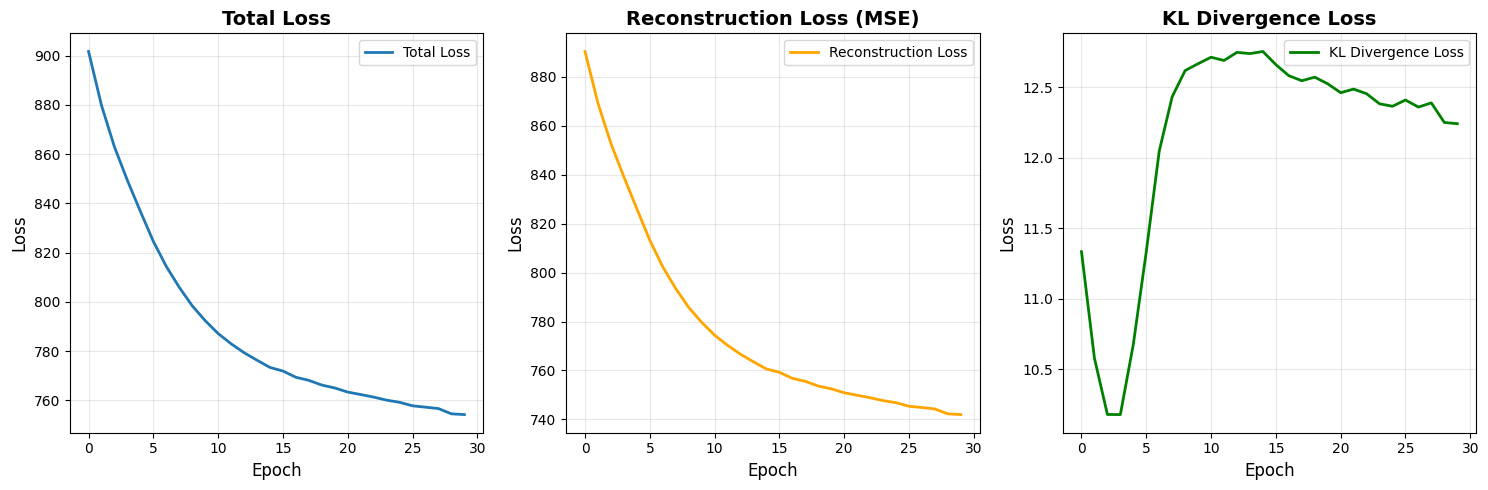

Training history plot saved as 'vae_training_history.png'


In [18]:
# Plot training history
plt.figure(figsize=(15, 5))

# Total Loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Total Loss', linewidth=2)
plt.title('Total Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Reconstruction Loss
plt.subplot(1, 3, 2)
plt.plot(history.history['reconstruction_loss'], label='Reconstruction Loss', linewidth=2, color='orange')
plt.title('Reconstruction Loss (MSE)', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# KL Divergence Loss
plt.subplot(1, 3, 3)
plt.plot(history.history['kl_loss'], label='KL Divergence Loss', linewidth=2, color='green')
plt.title('KL Divergence Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('vae_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training history plot saved as 'vae_training_history.png'")

## 8. Calculate EXO Stability Index

The **EXO Stability Index** is calculated as:
1. Generate reconstructions for test data
2. Calculate reconstruction error (MSE) for each sample
3. Convert error to stability score: `Score = max(0, 100 - Error * Scaling_Factor)`

Higher scores indicate more stable/normal periods, lower scores indicate anomalies.

In [19]:
# Generate reconstructions for test set
print("Generating reconstructions for test set...")
X_test_reconstructed = vae.predict(X_test)

# Calculate reconstruction error for each sample
reconstruction_errors = np.mean(np.square(X_test - X_test_reconstructed), axis=(1, 2))

print(f"\nReconstruction Error Statistics:")
print(f"Mean: {np.mean(reconstruction_errors):.4f}")
print(f"Std: {np.std(reconstruction_errors):.4f}")
print(f"Min: {np.min(reconstruction_errors):.4f}")
print(f"Max: {np.max(reconstruction_errors):.4f}")

Generating reconstructions for test set...
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step

Reconstruction Error Statistics:
Mean: 0.8303
Std: 1.0974
Min: 0.2261
Max: 14.2915


In [20]:
# Calculate EXO Stability Index
# Scaling factor to convert error to 0-100 scale
# Adjust this based on your error distribution
scaling_factor = 50

# Calculate stability scores
exo_stability_index = np.maximum(0, 100 - (reconstruction_errors * scaling_factor))

print(f"\nEXO Stability Index Statistics:")
print(f"Mean: {np.mean(exo_stability_index):.2f}")
print(f"Std: {np.std(exo_stability_index):.2f}")
print(f"Min: {np.min(exo_stability_index):.2f}")
print(f"Max: {np.max(exo_stability_index):.2f}")

# Identify anomalies (low stability scores)
anomaly_threshold = 50  # Scores below this are considered anomalies
num_anomalies = np.sum(exo_stability_index < anomaly_threshold)
anomaly_percentage = (num_anomalies / len(exo_stability_index)) * 100

print(f"\nAnomalies detected: {num_anomalies} ({anomaly_percentage:.2f}%)")


EXO Stability Index Statistics:
Mean: 63.34
Std: 21.14
Min: 0.00
Max: 88.69

Anomalies detected: 1381 (16.88%)


## 9. Visualize EXO Stability Index

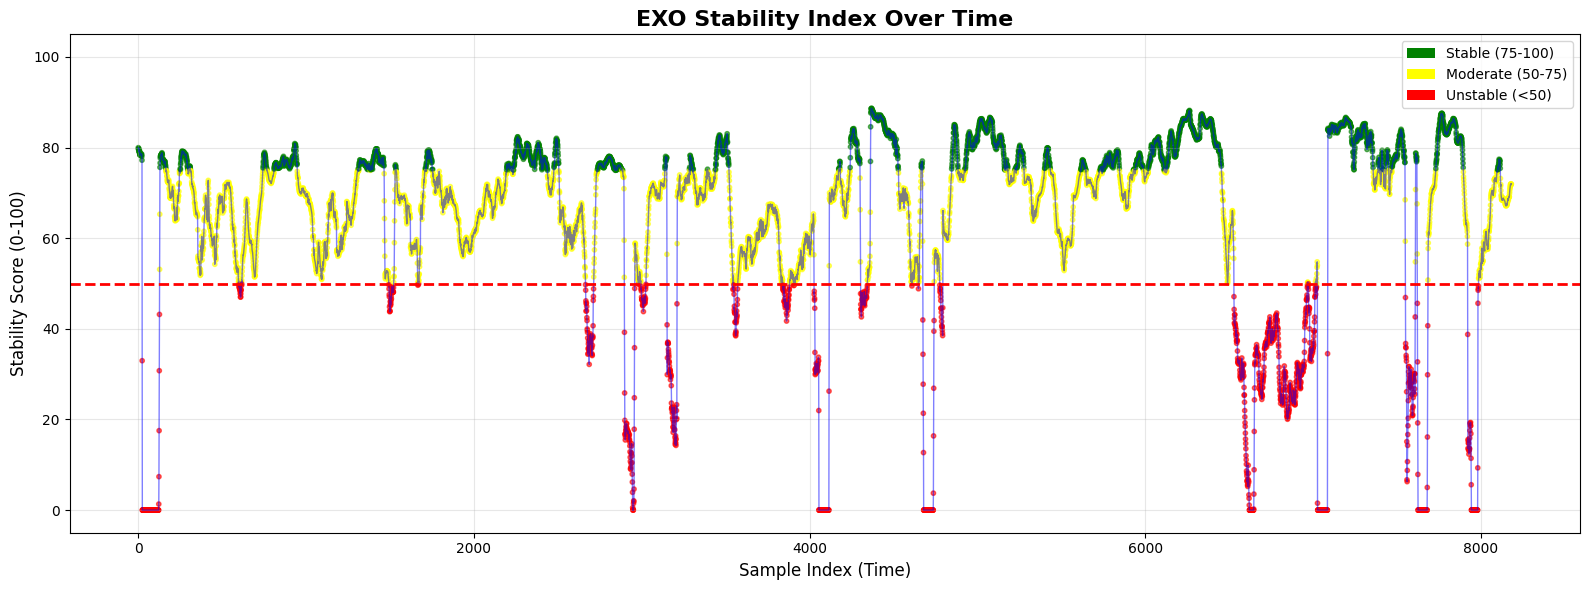

EXO Stability Index plot saved as 'exo_stability_index.png'


In [21]:
# Plot EXO Stability Index over time
plt.figure(figsize=(16, 6))

# Create color map: green for stable, yellow for moderate, red for unstable
colors = ['red' if score < 50 else 'yellow' if score < 75 else 'green' 
          for score in exo_stability_index]

plt.scatter(range(len(exo_stability_index)), exo_stability_index, 
           c=colors, alpha=0.6, s=10)
plt.plot(exo_stability_index, linewidth=1, alpha=0.5, color='blue')

# Add threshold line
plt.axhline(y=anomaly_threshold, color='red', linestyle='--', 
           linewidth=2, label=f'Anomaly Threshold ({anomaly_threshold})')

plt.title('EXO Stability Index Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Sample Index (Time)', fontsize=12)
plt.ylabel('Stability Score (0-100)', fontsize=12)
plt.ylim(-5, 105)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Add color legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', label='Stable (75-100)'),
    Patch(facecolor='yellow', label='Moderate (50-75)'),
    Patch(facecolor='red', label='Unstable (<50)')
]
plt.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig('exo_stability_index.png', dpi=300, bbox_inches='tight')
plt.show()

print("EXO Stability Index plot saved as 'exo_stability_index.png'")

## 10. Distribution Analysis

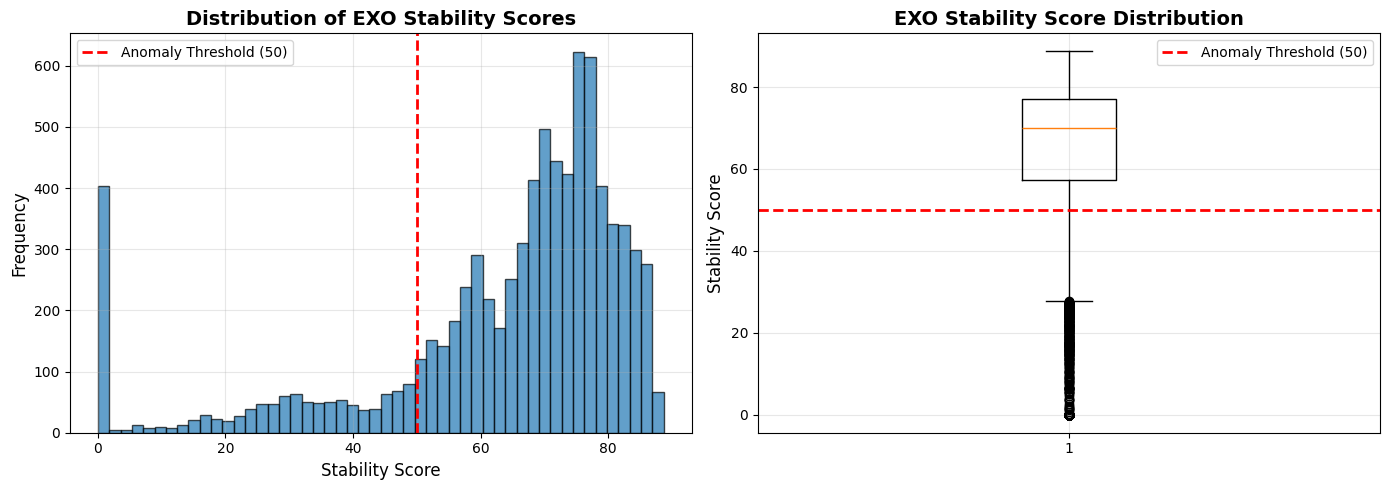

Distribution plot saved as 'stability_distribution.png'


In [22]:
# Plot distribution of stability scores
plt.figure(figsize=(14, 5))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(exo_stability_index, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=anomaly_threshold, color='red', linestyle='--', 
           linewidth=2, label=f'Anomaly Threshold ({anomaly_threshold})')
plt.title('Distribution of EXO Stability Scores', fontsize=14, fontweight='bold')
plt.xlabel('Stability Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Box plot
plt.subplot(1, 2, 2)
plt.boxplot(exo_stability_index, vert=True)
plt.axhline(y=anomaly_threshold, color='red', linestyle='--', 
           linewidth=2, label=f'Anomaly Threshold ({anomaly_threshold})')
plt.title('EXO Stability Score Distribution', fontsize=14, fontweight='bold')
plt.ylabel('Stability Score', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('stability_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Distribution plot saved as 'stability_distribution.png'")

## 11. Visualize Latent Space

256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step


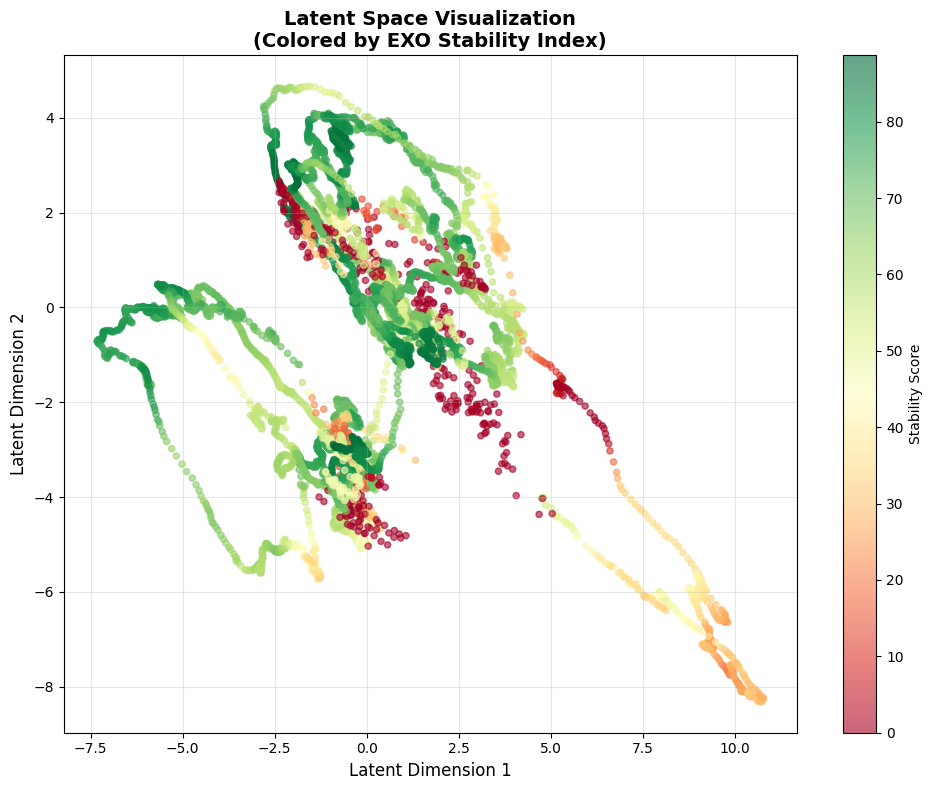

Latent space visualization saved as 'latent_space_visualization.png'


In [23]:
# Get latent space representations
z_mean_test, z_log_var_test, z_test = encoder.predict(X_test)

# Plot latent space colored by stability score
plt.figure(figsize=(10, 8))
scatter = plt.scatter(z_mean_test[:, 0], z_mean_test[:, 1], 
                     c=exo_stability_index, cmap='RdYlGn', 
                     alpha=0.6, s=20)
plt.colorbar(scatter, label='Stability Score')
plt.title('Latent Space Visualization\n(Colored by EXO Stability Index)', 
         fontsize=14, fontweight='bold')
plt.xlabel('Latent Dimension 1', fontsize=12)
plt.ylabel('Latent Dimension 2', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('latent_space_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("Latent space visualization saved as 'latent_space_visualization.png'")

## 12. Save the Model and Results

In [24]:
# Save the VAE model
vae.save('exo_vae_model.keras')
print("VAE model saved as 'exo_vae_model.keras'")

# Save the stability scores
np.save('exo_stability_index.npy', exo_stability_index)
print("Stability scores saved as 'exo_stability_index.npy'")

# Save reconstruction errors
np.save('reconstruction_errors.npy', reconstruction_errors)
print("Reconstruction errors saved as 'reconstruction_errors.npy'")

VAE model saved as 'exo_vae_model.keras'
Stability scores saved as 'exo_stability_index.npy'
Reconstruction errors saved as 'reconstruction_errors.npy'


## Summary

This notebook successfully implemented the **EXO-Model** using a Variational Autoencoder:

### Key Components:
1. **Encoder**: Compresses input data to a 2D latent space
2. **Decoder**: Reconstructs the original data from latent representation
3. **Custom Loss**: Combines reconstruction loss (MSE) and KL divergence

### EXO Stability Index:
- **High scores (75-100)**: Stable, normal behavior
- **Medium scores (50-75)**: Moderate stability
- **Low scores (<50)**: Anomalies, unstable periods

### Applications:
- Detect unusual patterns in physiological/behavioral data
- Monitor daily stability and identify concerning trends
- Early warning system for health/behavioral changes

The model learns what "normal" looks like from the training data, and any deviation from this learned pattern results in higher reconstruction error and lower stability scores.

In [29]:
import pandas as pd
import numpy as np

# 1. Load the Scores and Original Data
exo_stability_index = np.load('exo_stability_index.npy')
# Load the file that STILL HAS DATES (before you dropped them)
df_original = pd.read_csv('../data/cleaned/health_net_features_2_normalize.csv')

# 2. Re-create the Test Split logic to find the matching dates
# We used the last 20% for testing, minus the window size (60)
window_size = 60
split_index = int((len(df_original) - window_size) * 0.8)

# Get the dates corresponding to the Test Set
# Note: The predictions start at (split_index + window_size) because of the sliding window
test_dates = df_original['date'].iloc[split_index + window_size : ].reset_index(drop=True)

# 3. Create a Report DataFrame
report = pd.DataFrame({
    'Date': test_dates,
    'Stability_Score': exo_stability_index
})

# 4. Filter for Anomalies (Score < 50)
anomalies = report[report['Stability_Score'] < 50]

# 5. Group by Date to see which days were the worst
# We count how many "Anomalous Minutes" occurred on each day
daily_summary = anomalies.groupby('Date').size().reset_index(name='Anomalous_Minutes')
daily_summary = daily_summary.sort_values(by='Anomalous_Minutes', ascending=False)

print("=== TOP 5 MOST UNSTABLE DAYS ===")
print(daily_summary.head(5))

print("\n=== DETAILED LOOK AT THE WORST DAY ===")
worst_day = daily_summary.iloc[0]['Date']
print(f"Stats for {worst_day}:")
day_data = report[report['Date'] == worst_day]
print(f"Avg Stability Score: {day_data['Stability_Score'].mean():.1f}/100")
print(f"Lowest Score Hit:    {day_data['Stability_Score'].min():.1f}/100")

=== TOP 5 MOST UNSTABLE DAYS ===
         Date  Anomalous_Minutes
5  2025-12-02                549
3  2025-11-30                260
6  2025-12-03                187
2  2025-11-29                147
0  2025-11-27                104

=== DETAILED LOOK AT THE WORST DAY ===
Stats for 2025-12-02:
Avg Stability Score: 59.4/100
Lowest Score Hit:    0.0/100


In [32]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

# ==========================================
# 1. SETUP & DEFINITIONS (Required to load Custom Model)
# ==========================================

# Define Sampling Layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Define VAE Class
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

# ==========================================
# 2. LOAD DATA & REBUILD MODEL
# ==========================================
print("Loading data and model...")

# Load Data
X_test = np.load('X_test.npy')
exo_scores = np.load('exo_stability_index.npy')
df_original = pd.read_csv('health_net_features_2_normalize.csv')

# Rebuild Model Structure to load weights
num_samples, time_steps, num_features = X_test.shape
latent_dim = 2
intermediate_dim = 32

# Encoder
encoder_inputs = keras.Input(shape=(time_steps, num_features))
x = layers.Flatten()(encoder_inputs)
x = layers.Dense(intermediate_dim, activation='relu')(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
x = layers.Dense(time_steps * num_features, activation='linear')(x)
decoder_outputs = layers.Reshape((time_steps, num_features))(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name='decoder')

# Load Weights
vae = VAE(encoder, decoder)
vae.predict(X_test[:1], verbose=0) # Initialize
vae.load_weights('exo_vae_model.keras')

# ==========================================
# 3. RUN DIAGNOSIS WITH BIO-FILTER
# ==========================================
print("Diagnosing anomalies...")

# Get Feature Names
feature_names = df_original.drop(columns=['datetime', 'date', 'time', 'hour', 'minute', 
                                          'day_of_week', 'day_numeric']).columns.tolist()

# Get Test Dates
window_size = 60
split_index = int((len(df_original) - window_size) * 0.8)
test_dates = df_original['date'].iloc[split_index + window_size : ].reset_index(drop=True)

# Generate Reconstructions & Errors
reconstructions = vae.predict(X_test, verbose=0)
feature_errors = np.mean(np.square(X_test - reconstructions), axis=1)

# === THE FILTER ===
# Only these features count as "Biological Anomalies"
bio_features = [
    'heart_rate', 
    'stress_level', 
    'body_battery', 
    'sleep_duration_of_day', 
    'stress_rolling_mean_30',
    'stress_volatility_30'
]

diagnosis_list = []

for i in range(len(test_dates)):
    # Only look at Unstable Days (Score < 50)
    if i < len(exo_scores) and exo_scores[i] < 50:
        
        # Find the primary culprit
        culprit_idx = np.argmax(feature_errors[i])
        culprit_name = feature_names[culprit_idx]
        
        # CHECK: Is the culprit Biological?
        if culprit_name in bio_features:
            culprit_error = feature_errors[i][culprit_idx]
            
            diagnosis_list.append({
                'Date': test_dates[i],
                'Stability_Score': exo_scores[i],
                'Primary_Cause': culprit_name,
                'Error_Magnitude': culprit_error
            })

# ==========================================
# 4. GENERATE REPORT
# ==========================================
if not diagnosis_list:
    print("\nNo biological anomalies found! (All instabilities were likely Environmental/Digital)")
else:
    bio_diagnosis_df = pd.DataFrame(diagnosis_list)

    # Aggregate by Day
    bio_daily_report = bio_diagnosis_df.groupby('Date').agg({
        'Stability_Score': 'mean',          # Avg Score during bio-instability
        'Primary_Cause': lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0],
        'Date': 'count'                     # Minutes spent in bio-instability
    }).rename(columns={'Date': 'Bio_Unstable_Minutes'})

    # Sort by duration of instability
    bio_daily_report = bio_daily_report.sort_values(by='Bio_Unstable_Minutes', ascending=False)

    print("\n=======================================================")
    print("   TRUE BIOLOGICAL ANOMALIES (Filtered Report)         ")
    print("=======================================================")
    pd.set_option('display.max_rows', None)
    print(bio_daily_report[['Bio_Unstable_Minutes', 'Primary_Cause', 'Stability_Score']])
    print("=======================================================")

Loading data and model...
Diagnosing anomalies...

   TRUE BIOLOGICAL ANOMALIES (Filtered Report)         
            Bio_Unstable_Minutes         Primary_Cause  Stability_Score
Date                                                                   
2025-11-28                    16  stress_volatility_30        48.640648
2025-12-01                     8            heart_rate        40.652189
2025-12-03                     1            heart_rate        40.686899
